In [ ]:
# 1) download the dataset zip file from https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset/data
# in /content/sample_data dir
# 2) !unzip archive1.zip

!unzip '/content/sample_data/archive1.zip'
!pip install pandas numpy scikit-learn tensorflow keras opencv-python

Archive:  /content/sample_data/archive1.zip
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/0.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/1.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/10.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/100.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/101.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/102.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/103.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/104.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/105.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testin

In [ ]:
import tensorflow as tf
import os
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load labels
data_folder = "/content/Doctor’s Handwritten Prescription BD dataset"
label_file = data_folder + "/Training/training_labels.csv"

labels_df = pd.read_csv(label_file)

# Print column names to verify
print("labels_df.columns=",labels_df.columns)

Num GPUs Available:  0
labels_df.columns= Index(['IMAGE', 'MEDICINE_NAME', 'GENERIC_NAME'], dtype='object')


In [22]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Constants
IMG_SIZE = (64, 64)
NUM_CLASSES = 78
BATCH_SIZE = 32
EPOCHS = 3 #TODO change to 20
LEARNING_RATE = 0.001
SAVE_MODEL = 'prescription_classification_model.keras'

# def load_data(data_folder, filename_col='IMAGE', label_col='MEDICINE_NAME'):
def load_data(image_folder, label_file, filename_col='IMAGE', label_col='MEDICINE_NAME'):
    """
    Load images and labels from the specified folder and CSV file.
    """

    # Load labels
    labels_df = pd.read_csv(label_file)
    print(f"First few rows of the dataframe from {label_file}:")
    print(labels_df.head())

    # Load images and labels
    images, labels = [], []
    for _, row in labels_df.iterrows():
        img_path = os.path.join(image_folder, row[filename_col])
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        images.append(img)
        labels.append(row[label_col])

    # Convert lists to numpy arrays
    images = np.array(images, dtype="float32") / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels

def load_and_preprocess_data(data_folder):
    """
    Load and preprocess training, validation, and testing datasets.
    Returns X_train, y_train, X_valid, y_valid, X_test, y_test.
    """
    # Load and preprocess training data
    train_image_folder = os.path.join(data_folder, 'Training/training_words')
    train_label_file   = os.path.join(data_folder, 'Training/training_labels.csv')
    X_train, y_train_labels = load_data(train_image_folder, train_label_file)
    y_train, label_encoder = preprocess_labels(y_train_labels)

    # Load and preprocess validation data
    valid_image_folder = os.path.join(data_folder, 'Validation/validation_words')
    valid_label_file   = os.path.join(data_folder, 'Validation/validation_labels.csv')
    X_valid, y_valid_labels = load_data(valid_image_folder, valid_label_file)
    y_valid, _ = preprocess_labels(y_valid_labels)

    # Load and preprocess testing data
    test_image_folder = os.path.join(data_folder, 'Testing/testing_words')
    test_label_file   = os.path.join(data_folder, 'Testing/testing_labels.csv')
    X_test, y_test_labels = load_data(test_image_folder, test_label_file)
    y_test, _ = preprocess_labels(y_test_labels)

    return X_train, y_train, X_valid, y_valid, X_test, y_test


def preprocess_labels(labels):
    """
    Encode labels as integers and convert to categorical format.
    """
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = to_categorical(labels_encoded, num_classes=NUM_CLASSES)
    return labels_categorical, label_encoder

def build_model(input_shape=(64, 64, 3), num_classes=NUM_CLASSES):
    """
    Build a CNN model for image classification.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def compile_model(model, learning_rate=LEARNING_RATE):
    """
    Compile the model with specified optimizer, loss, and metrics.
    """
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE, epochs=EPOCHS):
    """
    Train the model with training data and validate on test data.
    """
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set.
    """
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    return loss, accuracy

def save_model(model, filename=SAVE_MODEL):
    """
    Save the trained model to disk.
    """
    model.save(filename)


# Main workflow
def main(data_folder):

    # Load and preprocess data
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_and_preprocess_data(data_folder)

    # Build, compile and train model
    model = build_model(input_shape=IMG_SIZE + (3,))
    model = compile_model(model)
    history = train_model(model, X_train, y_train, X_valid, y_valid)

    save_model(model) #save it so I can train it again.

    #Evaluate and save the model
    evaluate_model(model, X_test, y_test)
    # save_model(model)


# If this script is run directly, execute the main function
if __name__ == "__main__":
    data_folder = "/content/Doctor’s Handwritten Prescription BD dataset"
    main(data_folder)


First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 250ms/step - accuracy: 0.0097 - loss: 4.3689 - val_accuracy: 0.0346 - val_loss: 4.2584
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 237ms/step - accuracy: 0.0574 - loss: 4.1340 - val_accuracy: 0.2987 - val_loss: 3.1284
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.3024 - loss: 2.8669 - val_accuracy: 0.5192 - val_loss: 2.0278
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3834 - loss: 2.4973
Test Accuracy: 38.59%


First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta 

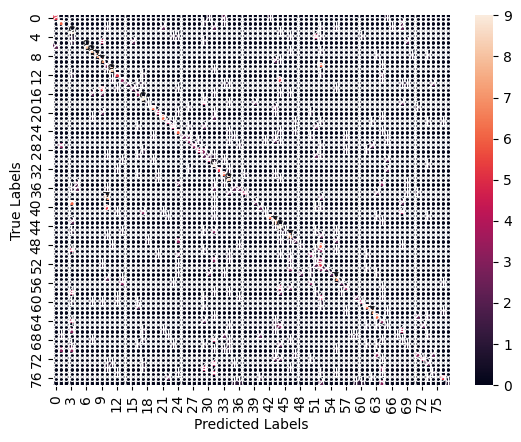

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, y_train, X_valid, y_valid, X_test, y_test = load_and_preprocess_data(data_folder)

# Generate predictions and create confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.46      0.60      0.52        10
           2       0.00      0.00      0.00        10
           3       0.21      0.90      0.35        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       1.00      0.80      0.89        10
           7       0.62      0.80      0.70        10
           8       1.00      0.70      0.82        10
           9       0.32      0.70      0.44        10
          10       0.12      0.30      0.18        10
          11       0.73      0.80      0.76        10
          12       0.45      0.50      0.48        10
          13       0.33      0.30      0.32        10
          14       1.00      0.20      0.33        10
          15       0.50      0.20      0.29        10
          16       0.27      0.30      0.29        10
          17       0.47    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
#Now we retrain the model using data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Load the trained model that was saved earlier
SAVE_MODEL = 'prescription_classification_model.keras'
model = load_model(SAVE_MODEL)

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

X_train, y_train, X_valid, y_valid, X_test, y_test = load_and_preprocess_data(data_folder)

# Fit the generator to the training data
datagen.fit(X_train)

# Train the model with augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_valid, y_valid), epochs=4)

#Evalute the mmodel on new augmentated data
evaluate_model(model, X_test, y_test)



First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 283ms/step - accuracy: 0.1406 - loss: 3.7490 - val_accuracy: 0.4167 - val_loss: 2.3586
Epoch 2/4
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 278ms/step - accuracy: 0.2049 - loss: 3.2917 - val_accuracy: 0.3910 - val_loss: 2.5197
Epoch 3/4
98/98 ━━━━━━━━━━━━━━━━━━━━ 49s 364ms/step - accuracy: 0.2472 - loss: 3.0059 - val_accuracy: 0.4679 - val_loss: 2.0272
Epoch 4/4
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.2755 - loss: 2.8001 - val_accuracy: 0.5436 - val_loss: 1.7948
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4897 - loss: 2.1822
Test Accuracy: 44.10%


(2.4257144927978516, 0.44102564454078674)